In [2]:
from utils import clean_and_split_file

In [4]:
8 / 134

0.05970149253731343

In [5]:
5/95

0.05263157894736842

In [3]:
clean_and_split_file('../data/cantrbry/alice29.txt', 'datasets/alice', .9, .05, .05)

In [6]:
''.join(filter(lambda x: x in set('gosho'), 'poehso'))

'ohso'

In [58]:
import codecs
import sys
import os
import numpy as np
from datautils.dataset import Alphabet, Dataset
from models.rnn import RNN_LM
from training import train_rnn, evaluate_rnn
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch

In [59]:
# filename = '../data/enwik8/enwik8.txt'
# filename_train = '../data/lotr/lotr_fotr_train_u.txt'
# filename_train = '../data/alice29_alpha_train.9.txt'
filename_train = '../data/alice29.txt'

filename_val = '../data/alice29_alpha_test.1.txt'

alph = Alphabet.from_text(filename_train)

data_train = Dataset(filename_train, alph)
data_val = Dataset(filename_val, alph)

with open(filename_train) as fp:
    text = fp.read()

alphabet_size = alph.get_size()
hidden_dim = alphabet_size
num_timesteps = 64
use_gpu = True
batch_size = 20
plot_every = 50
hidden_state_reset_interval = 100

In [61]:
%%time
torch.manual_seed(1231)

model = RNN_LM(alphabet_size=alphabet_size, hidden_dim=hidden_dim, batch_size=batch_size, num_layers=1,
               use_gpu=use_gpu, network_type='lstm', recurrent_dropout=0)

loss_function = nn.modules.loss.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

if use_gpu:
    model.cuda()

step = 0
losses = []
total_train_loss = 0
running_train_loss = 0
loss_records = 0
loss_steps = 0


for epoch_number in range(2):
    batch_iterator = data_train.get_batch_iterator(batch_size, num_timesteps)
    for inputs, targets in batch_iterator:
        if use_gpu:
            inputs = Variable(torch.Tensor(inputs)).cuda()
            targets = Variable(torch.LongTensor(targets)).cuda()
        else:
            inputs = Variable(torch.Tensor(inputs))
            targets = Variable(torch.LongTensor(targets))
        
        model.zero_grad()
        
#         TODO: reset hidden state at given intervals (problems with backprop)
        if step % hidden_state_reset_interval == 0:
            model.hidden = model.init_hidden()
        else:
            old_hidden_values = model.get_hidden_data()
            model.hidden = model.init_hidden(batch_size=None, init_values=old_hidden_values)
            
        
        logits = model(inputs)
        
        loss = loss_function(logits.view(-1, alphabet_size), targets.view(-1))
        total_train_loss += loss.data[0]
        
        loss.backward()
        
        optimizer.step()
        step += 1
        
        if step % plot_every == 0:
            loss_records += 1
            # calculate validation loss
            
            # Initialize hidden states with a batch size of 1 for evaluation
            old_hidden = model.hidden
            model.hidden = model.init_hidden(batch_size=1)
            
            #TODO: Make sure we iterate through whole file when validating
            val_iterator = data_val.get_batch_iterator(1, batch_size * num_timesteps)
            val_loss = 0
            v_steps = 0
            for v_inp, v_tar in val_iterator:
                if use_gpu:
                    v_inp = Variable(torch.Tensor(v_inp)).cuda()
                    v_tar = Variable(torch.LongTensor(v_tar)).cuda()
                else:
                    v_inp = Variable(torch.Tensor(v_inp))
                    v_tar = Variable(torch.LongTensor(v_tar))
                v_logits = model(v_inp)
                
                val_loss += loss_function(v_logits.view(-1, alphabet_size), v_tar.view(-1)).data[0]
                v_steps += 1

            # Set hidden states to original ones
            model.hidden = old_hidden
            
            iter_train_loss = total_train_loss / plot_every
            running_train_loss = running_train_loss * ((loss_records - 1) / loss_records) + \
                iter_train_loss * (1 / loss_records)
            
#             losses.append([step, total_train_loss / plot_every, val_loss / v_steps])
            losses.append([step, iter_train_loss, running_train_loss, val_loss / v_steps])

            total_train_loss = 0

CPU times: user 4.36 s, sys: 420 ms, total: 4.78 s
Wall time: 5.32 s


In [19]:
model.hidden = model.init_hidden(batch_size=1)
            
#TODO: Make sure we iterate through whole file when validating
val_iterator = data_val.get_batch_iterator(1, batch_size * num_timesteps)
val_loss = 0
v_steps = 0
for v_inp, v_tar in val_iterator:
    if use_gpu:
        v_inp = Variable(torch.Tensor(v_inp)).cuda()
        v_tar = Variable(torch.LongTensor(v_tar)).cuda()
    else:
        v_inp = Variable(torch.Tensor(v_inp))
        v_tar = Variable(torch.LongTensor(v_tar))
    v_logits = model(v_inp)

    val_loss += loss_function(v_logits.view(-1, alphabet_size), v_tar.view(-1)).data[0]
    v_steps += 1

val_loss / v_steps

2.034505569934845

In [30]:
bi = data_val.get_batch_iterator(1, 128)
model.hidden = model.init_hidden(batch_size=1)
val_loss = 0
val_loss1 = 0
val_steps = 0
for inputs, targets in bi:
    if use_gpu:
        inputs = Variable(torch.Tensor(inputs)).cuda()
        targets = Variable(torch.LongTensor(targets)).cuda()
    else:
        inputs = Variable(torch.Tensor(inputs))
        targets = Variable(torch.LongTensor(targets))
    logits = model(inputs)
    loss = loss_function(logits.view(-1, alphabet_size), targets.view(-1))
    loss1 = 0
    for ls, ts in zip(logits, targets):
        loss1 += loss_function(ls, ts)
    val_loss += loss.data[0]
    val_loss1 += loss1.data[0]
    
    val_steps += 1

val_loss / val_steps

1.7764518024786464

In [13]:
torch.save(model, 'model.pt')

In [14]:
torch.save(model.state_dict(), 'model_sd.sd')

In [18]:
model.load_state_dict(torch.load('model_sd.sd'))

In [3]:
model = torch.load('model_sd.sd')

In [12]:
model = torch.load('model.pt')
model.rnn.flatten_parameters()

In [5]:
%%time
model = RNN_LM(alphabet_size=alphabet_size, hidden_dim=hidden_dim, batch_size=batch_size, num_layers=1,
               use_gpu=use_gpu, network_type='lstm', recurrent_dropout=0)

loss_function = nn.modules.loss.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses1, val_loss = train_rnn(model, data_train, data_val, batch_size, num_timesteps, hidden_state_reset_interval, 100,
                    optimizer, True, plot_every)

CPU times: user 3min 49s, sys: 21.7 s, total: 4min 10s
Wall time: 4min 10s


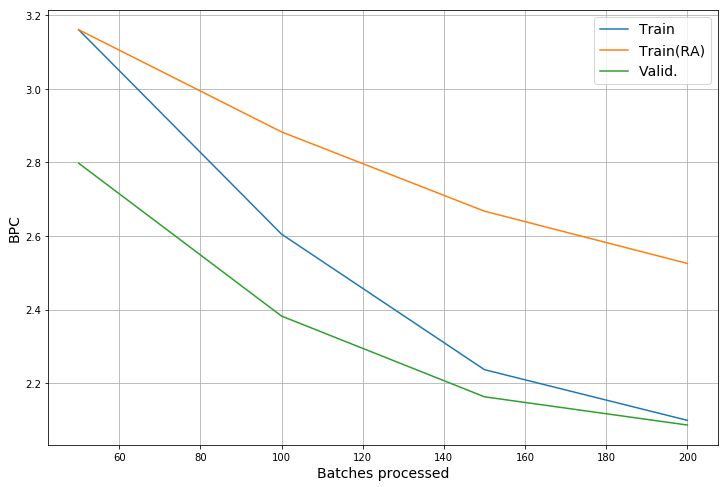

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

losses = np.array(losses)
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(losses[:, 0], losses[:, 1], label='Train')
plt.plot(losses[:, 0], losses[:, 2], label='Train(RA)')
plt.plot(losses[:, 0], losses[:, 3], label='Valid.')
plt.legend(fontsize=14)

plt.xlabel('Batches processed', fontsize=14)
plt.ylabel('BPC', fontsize=14)

plt.savefig()

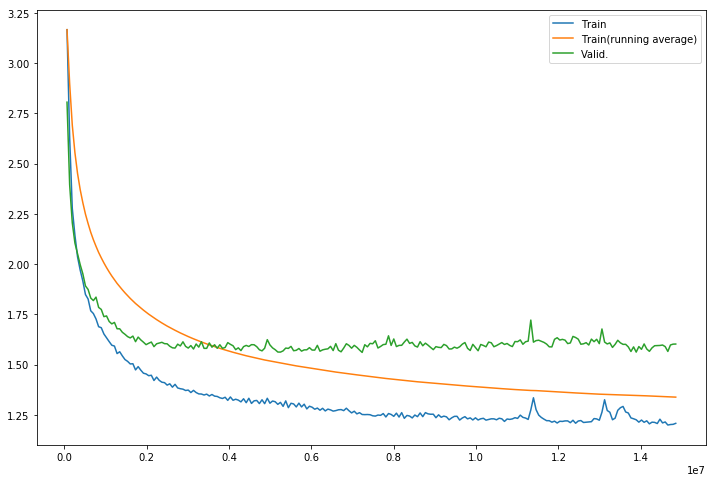

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

losses1 = np.array(losses1)
plt.figure(figsize=(12, 8))
plt.plot(losses1[:, 0], losses1[:, 1], label='Train')
plt.plot(losses1[:, 0], losses1[:, 2], label='Train(running average)')
plt.plot(losses1[:, 0], losses1[:, 3], label='Valid.')
plt.legend()

In [1]:
import json
from itertools import product
with open('experiments/alice_test/spec.json') as fp:
    spec = json.load(fp)

In [2]:
vals = spec['hyperparams'].values()

In [3]:
combs = list(product(*vals))
combs

[('lstm', 0, 1, 10, 100, 1000, 'SGD', 0.1, 20, 0, 0, 0),
 ('lstm', 0, 1, 10, 100, 1000, 'SGD', 0.01, 20, 0, 0, 0)]

In [ ]:
torch.save()

In [4]:
dict(zip(spec['hyperparams'].keys(), combs[0]))

{'batch_size': 10,
 'hidden_size': 0,
 'l2_penalty': 0,
 'learning_rate': 0.1,
 'linear_dropout': 0,
 'network_type': 'lstm',
 'num_epochs': 20,
 'num_layers': 1,
 'num_timesteps': 100,
 'optimizer': 'SGD',
 'recurrent_dropout': 0,
 'reset_state_every': 1000}

In [5]:
from utils import dict_of_lists_to_list_of_dicts
hps = dict_of_lists_to_list_of_dicts(spec['hyperparams'])

In [6]:
from trainutils.trainutils import Hyperparameters

h = Hyperparameters(**hps[0])

In [17]:
print(h.__dict__.))

AttributeError: 'dict' object has no attribute 'to_strin'

In [18]:
with open('experiments/test_small/spec.json') as fp:
    s = json.load(fp)

In [19]:
s

{'alphabet_file': '',
 'data_folder': 'test_small',
 'hyperparams': {'1': {'batch_size': [2],
   'hidden_size': [0],
   'l2_penalty': [0],
   'learning_rate': [0.1],
   'linear_dropout': [0],
   'network_type': ['lstm'],
   'num_epochs': [2],
   'num_layers': [1],
   'num_timesteps': [20, 30],
   'optimizer': [{'name': 'SGD'}],
   'recurrent_dropout': [0],
   'reset_state_every': [120]},
  '2': {'batch_size': [4],
   'hidden_size': [0],
   'l2_penalty': [0],
   'learning_rate': [0.1],
   'linear_dropout': [0],
   'network_type': ['lstm'],
   'num_epochs': [2],
   'num_layers': [1],
   'num_timesteps': [10, 15],
   'optimizer': ['SGD'],
   'recurrent_dropout': [0],
   'reset_state_every': [120]}},
 'model': 'rnn'}

In [22]:
os.path.getsize('model.pt') / os.path.getsize('model_sd.sd')

1.0522895483996215

In [54]:
a = dict(c=5, d=None)
json.dump()

In [55]:
import json

with open('sth.json', 'w+') as fp:
    json.dump(a, fp)

In [56]:
!cat sth.json

{"c": 5, "d": null}

In [56]:
import numpy as np

B = 4
T = 10
alph_size = 11

ids = np.arange(115)
# ids = np.random.randint(0, alph_size, 115)
print(len(ids))

nt_p, r = divmod(len(ids), B)
print(r)
ids = ids[:len(ids) - r]
print(len(ids))


n, p = divmod(nt_p, T)
print(n, p)

print(ids.reshape(B, -1)[:, :10])
# ids.reshape(batch_size, -1,  n_ts).transpose(1, 0, 2)

encs = np.zeros((len(ids), alph_size))
for i, r in enumerate(encs):
    r[ids[i] % alph_size] = 1

np.argmax(encs, 1)

np.argmax(encs.reshape(B, (n * T + p), alph_size)[:, :10, :], 2)
# np.argmax(encs.reshape(B, (n * T + p), alph_size)[:10], 2)

115
3
112
2 8
[[ 0  1  2  3  4  5  6  7  8  9]
 [28 29 30 31 32 33 34 35 36 37]
 [56 57 58 59 60 61 62 63 64 65]
 [84 85 86 87 88 89 90 91 92 93]]


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 6,  7,  8,  9, 10,  0,  1,  2,  3,  4],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 7,  8,  9, 10,  0,  1,  2,  3,  4,  5]])

In [40]:
encs.shape

(112, 7)